In [1]:
# for inspiration: https://colab.research.google.com/drive/1jGja4e-x97wxfdLyAA_XIGLwAd35JUNb

Install lsdb (and transitively hipscat)

In [2]:
!pip install -r requirements.txt --quiet

In [3]:
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
import hipscat as hc
from hipscat.inspection.almanac import Almanac
from hipscat.inspection.almanac_info import AlmanacInfo

'Version of lsdb is %s' % lsdb.__version__

'Version of lsdb is 0.2.2'

In [4]:
import dask
from dask.distributed import Client
# initialize dask client 
Client = Client(n_workers=2, threads_per_worker=1, memory_limit='8Gb')

In [5]:
# These are locations where the catalogs are stored if you want to acces via internet

# GAIA
# gaia_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia"

# ZTF
# ztf_object_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/"
# ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_source/"

# but we have these catalogs avaliable via AWS buckets
BUCKET = "irsa-mast-tike-spitzer-data"
GAIA_PATH = f"s3://{BUCKET}/data/GAIA/dr3/gaiasource/hipscat/gaia-dr3-gaiasource-hipscat"
ZTF_OBJECTS_PATH = f"s3://{BUCKET}/data/ZTF/dr20/objects/hipscat/ztf-dr20-objects-hipscat"
# ZTF_SOURCES_PATH = f"s3://{BUCKET}/data/ZTF/dr20/lc/hipscat/ztf-dr20-lc-hipscat"  # not yet available

In [6]:
%%time

# load lite version of Gaia DR3 for quick cone searches
# we load only ra, dec columns, and small sections of the sky
gaia_lite = lsdb.read_hipscat(GAIA_PATH, columns=["ra", "dec"], search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=1*3600))
gaia_cone = lsdb.read_hipscat(GAIA_PATH, search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=1*3600))
# This is loading the full GAIA catalog
gaia = lsdb.read_hipscat(GAIA_PATH)

# This is loading the full ZTF catalog
ztf = lsdb.read_hipscat(ZTF_OBJECTS_PATH) # ZTF Object
# ztf_source = lsdb.read_hipscat(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 1.11 s, sys: 94.1 ms, total: 1.21 s
Wall time: 3.18 s


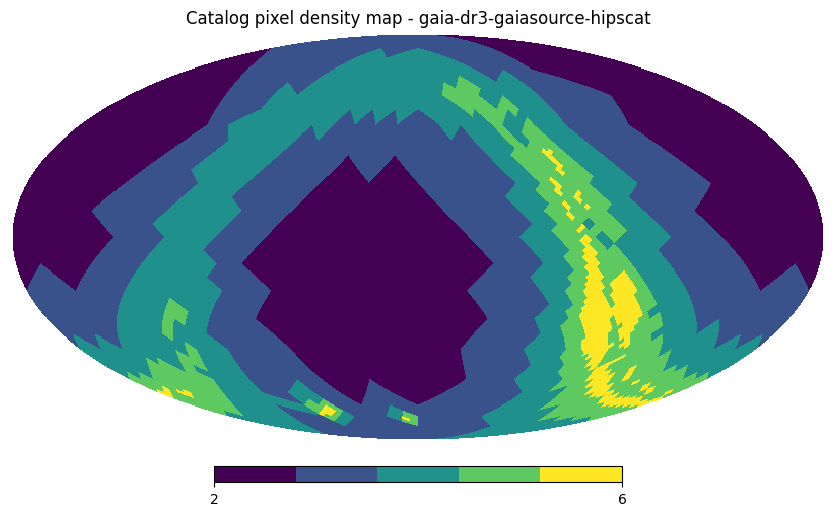

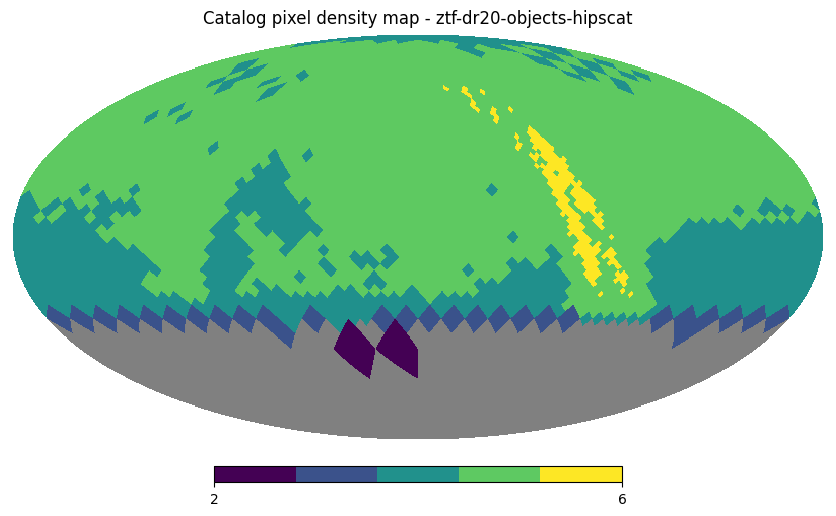

In [7]:
# Plot the Pixel Density Maps for Gaia and ZTF

plot_pixels(gaia.hc_structure)
plot_pixels(ztf.hc_structure)
# plot_pixels(ztf_source.hc_structure)

In [8]:
%%time 
# Cross-match Gaia and ZTF
# Observe this is only lazy loaded
xmatch_object = gaia_lite.crossmatch(ztf)
xmatch_object

CPU times: user 65.1 ms, sys: 7.7 ms, total: 72.8 ms
Wall time: 70.5 ms


/opt/conda/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_gaia-dr3-gaiasource-hipscat,dec_gaia-dr3-gaiasource-hipscat,oid_ztf-dr20-objects-hipscat,ra_ztf-dr20-objects-hipscat,dec_ztf-dr20-objects-hipscat,htm20_ztf-dr20-objects-hipscat,field_ztf-dr20-objects-hipscat,ccdid_ztf-dr20-objects-hipscat,qid_ztf-dr20-objects-hipscat,fid_ztf-dr20-objects-hipscat,filtercode_ztf-dr20-objects-hipscat,transient_ztf-dr20-objects-hipscat,x_ztf-dr20-objects-hipscat,y_ztf-dr20-objects-hipscat,z_ztf-dr20-objects-hipscat,astrometricrms_ztf-dr20-objects-hipscat,chisq_ztf-dr20-objects-hipscat,con_ztf-dr20-objects-hipscat,lineartrend_ztf-dr20-objects-hipscat,magrms_ztf-dr20-objects-hipscat,maxmag_ztf-dr20-objects-hipscat,maxslope_ztf-dr20-objects-hipscat,meanmag_ztf-dr20-objects-hipscat,medianabsdev_ztf-dr20-objects-hipscat,medianmag_ztf-dr20-objects-hipscat,medmagerr_ztf-dr20-objects-hipscat,minmag_ztf-dr20-objects-hipscat,nabovemeanbystd_1_ztf-dr20-objects-hipscat,nabovemeanbystd_3_ztf-dr20-objects-hipscat,nabovemeanbystd_5_ztf-dr20-objects-hipscat,nbelowmeanbystd_1_ztf-dr20-objects-hipscat,nbelowmeanbystd_3_ztf-dr20-objects-hipscat,nbelowmeanbystd_5_ztf-dr20-objects-hipscat,nconsecabovemeanbystd_1_ztf-dr20-objects-hipscat,nconsecabovemeanbystd_3_ztf-dr20-objects-hipscat,nconsecabovemeanbystd_5_ztf-dr20-objects-hipscat,nconsecbelowmeanbystd_1_ztf-dr20-objects-hipscat,nconsecbelowmeanbystd_3_ztf-dr20-objects-hipscat,nconsecbelowmeanbystd_5_ztf-dr20-objects-hipscat,nconsecfrommeanbystd_1_ztf-dr20-objects-hipscat,nconsecfrommeanbystd_3_ztf-dr20-objects-hipscat,nconsecfrommeanbystd_5_ztf-dr20-objects-hipscat,ngoodobs_ztf-dr20-objects-hipscat,ngoodobsrel_ztf-dr20-objects-hipscat,nmedianbufferrange_ztf-dr20-objects-hipscat,nobs_ztf-dr20-objects-hipscat,nobsrel_ztf-dr20-objects-hipscat,npairposslope_ztf-dr20-objects-hipscat,percentiles_05_ztf-dr20-objects-hipscat,percentiles_10_ztf-dr20-objects-hipscat,percentiles_175_ztf-dr20-objects-hipscat,percentiles_25_ztf-dr20-objects-hipscat,percentiles_325_ztf-dr20-objects-hipscat,percentiles_40_ztf-dr20-objects-hipscat,percentiles_60_ztf-dr20-objects-hipscat,percentiles_675_ztf-dr20-objects-hipscat,percentiles_75_ztf-dr20-objects-hipscat,percentiles_825_ztf-dr20-objects-hipscat,percentiles_90_ztf-dr20-objects-hipscat,percentiles_95_ztf-dr20-objects-hipscat,refchi_ztf-dr20-objects-hipscat,refmag_ztf-dr20-objects-hipscat,refmagerr_ztf-dr20-objects-hipscat,refsharp_ztf-dr20-objects-hipscat,refsnr_ztf-dr20-objects-hipscat,skewness_ztf-dr20-objects-hipscat,smallkurtosis_ztf-dr20-objects-hipscat,stetsonj_ztf-dr20-objects-hipscat,stetsonk_ztf-dr20-objects-hipscat,uncalibmeanmag_ztf-dr20-objects-hipscat,vonneumannratio_ztf-dr20-objects-hipscat,weightedmagrms_ztf-dr20-objects-hipscat,weightedmeanmag_ztf-dr20-objects-hipscat,Norder_ztf-dr20-objects-hipscat,Dir_ztf-dr20-objects-hipscat,Npix_ztf-dr20-objects-hipscat,_dist_arcsec
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3643412098542731264,float64,float64,int64,float64,float64,int64,int32,int8,int8,int8,string,int8,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint64,uint64,float64
3644537998449573888,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [9]:
%%time
# Load into memory, the first partition
xmatch_object.head(5)

CPU times: user 522 ms, sys: 60.5 ms, total: 582 ms
Wall time: 13.6 s


Exception ignored in: <function AbstractMOC.__del__ at 0x7ff954074550>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/mocpy/abstract_moc.py", line 24, in __del__
    mocpy.drop(self.store_index)
OSError: MOC at index '1' not found


,ra_gaia-dr3-gaiasource-hipscat,dec_gaia-dr3-gaiasource-hipscat,oid_ztf-dr20-objects-hipscat,ra_ztf-dr20-objects-hipscat,dec_ztf-dr20-objects-hipscat,htm20_ztf-dr20-objects-hipscat,field_ztf-dr20-objects-hipscat,ccdid_ztf-dr20-objects-hipscat,qid_ztf-dr20-objects-hipscat,fid_ztf-dr20-objects-hipscat,...,stetsonj_ztf-dr20-objects-hipscat,stetsonk_ztf-dr20-objects-hipscat,uncalibmeanmag_ztf-dr20-objects-hipscat,vonneumannratio_ztf-dr20-objects-hipscat,weightedmagrms_ztf-dr20-objects-hipscat,weightedmeanmag_ztf-dr20-objects-hipscat,Norder_ztf-dr20-objects-hipscat,Dir_ztf-dr20-objects-hipscat,Npix_ztf-dr20-objects-hipscat,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3643412099679387648,300.938807,16.959530,592204100094175,300.938801,16.959553,13844633847308,592,4,1,2,...,NaN,NaN,0.0,1.939633,NaN,NaN,5,0,3236,0.083917
3643412100069457920,300.939196,16.960282,1588112200070698,300.939201,16.960285,13844633847466,1588,12,2,1,...,NaN,NaN,0.0,1.166992,NaN,NaN,5,0,3236,0.019159
3643412100413390848,300.938070,16.960664,592204100052864,300.938039,16.960796,13844633849518,592,4,1,2,...,NaN,NaN,0.0,1.919086,NaN,NaN,5,0,3236,0.488199
3643412102065946624,300.938019,16.961057,1587209100054186,300.938038,16.960851,13844633849618,1587,9,1,2,...,NaN,NaN,0.0,1.669878,NaN,NaN,5,0,3236,0.741758
3643412107736645632,300.934457,16.961220,1587209100009396,300.934453,16.961229,13844633633402,1587,9,1,2,...,NaN,NaN,0.0,1.800377,NaN,NaN,5,0,3236,0.032158


We can maintain an "almanac" of known catalogs. In this way, we can find new catalogs, or refer to them with simpler names.

In [10]:
almanac = Almanac(dirs = "/home/jovyan/efs/lincc/almanac")
almanac.catalogs()

['gaia', 'gaia_s3', 'ztf_dr14', 'ztf_s3']

In [11]:
# gaia_hc = almanac.get_catalog("gaia")
#gaia = lsdb.read_hipscat(gaia_hc.catalog_base_dir)

In [12]:
%%time
ztf.head(1)

CPU times: user 161 ms, sys: 25.1 ms, total: 186 ms
Wall time: 4.76 s


,oid,ra,dec,htm20,field,ccdid,qid,fid,filtercode,transient,...,smallkurtosis,stetsonj,stetsonk,uncalibmeanmag,vonneumannratio,weightedmagrms,weightedmeanmag,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
994050048,1447207200005802,44.999782,0.001902,17386027615220,1447,7,2,2,zr,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0


In [13]:
ztf.head(1).columns

Index(['oid', 'ra', 'dec', 'htm20', 'field', 'ccdid', 'qid', 'fid',
       'filtercode', 'transient', 'x', 'y', 'z', 'astrometricrms', 'chisq',
       'con', 'lineartrend', 'magrms', 'maxmag', 'maxslope', 'meanmag',
       'medianabsdev', 'medianmag', 'medmagerr', 'minmag', 'nabovemeanbystd_1',
       'nabovemeanbystd_3', 'nabovemeanbystd_5', 'nbelowmeanbystd_1',
       'nbelowmeanbystd_3', 'nbelowmeanbystd_5', 'nconsecabovemeanbystd_1',
       'nconsecabovemeanbystd_3', 'nconsecabovemeanbystd_5',
       'nconsecbelowmeanbystd_1', 'nconsecbelowmeanbystd_3',
       'nconsecbelowmeanbystd_5', 'nconsecfrommeanbystd_1',
       'nconsecfrommeanbystd_3', 'nconsecfrommeanbystd_5', 'ngoodobs',
       'ngoodobsrel', 'nmedianbufferrange', 'nobs', 'nobsrel', 'npairposslope',
       'percentiles_05', 'percentiles_10', 'percentiles_175', 'percentiles_25',
       'percentiles_325', 'percentiles_40', 'percentiles_60',
       'percentiles_675', 'percentiles_75', 'percentiles_825',
       'percentiles_

You'll need to set the suffixes of the resulting join table, so you can query using those column names.

```
... , suffixes=("_gaia", "_ztf") ...
```

In [14]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia_cone.crossmatch(ztf, suffixes=("_gaia", "_ztf")).query(
    "parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 160 ms, sys: 595 µs, total: 161 ms
Wall time: 156 ms


/opt/conda/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [15]:
%time 
# fails at 4 moment
all_sky_object = _all_sky_object.compute()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


Exception ignored in: <function AbstractMOC.__del__ at 0x7f8f97660670>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/mocpy/abstract_moc.py", line 24, in __del__
    mocpy.drop(self.store_index)
OSError: MOC at index '1' not found
Exception ignored in: <function AbstractMOC.__del__ at 0x7f8f97660670>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/mocpy/abstract_moc.py", line 24, in __del__
    mocpy.drop(self.store_index)
OSError: MOC at index '1' not found
Exception ignored in: <function AbstractMOC.__del__ at 0x7f8f97660670>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/mocpy/abstract_moc.py", line 24, in __del__
    mocpy.drop(self.store_index)
OSError: MOC at index '1' not found
Exception ignored in: <function AbstractMOC.__del__ at 0x7ff954074550>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/mocpy/abstract_moc.py", line 24, in __del__
 

In [16]:
all_sky_object

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,stetsonj_ztf,stetsonk_ztf,uncalibmeanmag_ztf,vonneumannratio_ztf,weightedmagrms_ztf,weightedmeanmag_ztf,Norder_ztf,Dir_ztf,Npix_ztf,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3643413275007254528,1636148068921376768,Gaia DR3 1821706637701187200,1821706637701187200,372376383,2016.0,300.994010,0.031234,17.012684,0.024773,0.608951,...,0.0,0.0,0.0,0.000000,0.0,0.0,5,0,3236,0.067009
3643414806045655040,1636148068921376768,Gaia DR3 1821707393615573888,1821707393615573888,270237472,2016.0,300.918962,0.032737,17.045524,0.027808,0.390358,...,NaN,NaN,0.0,1.289726,NaN,NaN,5,0,3236,0.068384
3643415430317473792,1636148068921376768,Gaia DR3 1821707698546214272,1821707698546214272,864928606,2016.0,300.941856,0.052227,17.048924,0.044048,1.167348,...,0.0,0.0,0.0,0.000000,0.0,0.0,5,0,3236,0.114386
3643416488817197056,1636148068921376768,Gaia DR3 1821708213935407488,1821708213935407488,1598760376,2016.0,300.934786,0.033041,17.107908,0.031840,0.514579,...,0.0,0.0,0.0,0.000000,0.0,0.0,5,0,3236,0.053573
3643416611496394752,1636148068921376768,Gaia DR3 1821708286968620672,1821708286968620672,1668236203,2016.0,301.028256,0.038429,17.055523,0.036194,0.372974,...,0.0,0.0,0.0,0.000000,0.0,0.0,5,0,3236,0.088709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654668561038704640,1636148068921376768,Gaia DR3 1827334281830541696,1827334281830541696,1593306307,2016.0,299.556261,0.085373,23.241655,0.095573,1.026298,...,NaN,NaN,0.0,1.710872,NaN,NaN,6,10000,12983,0.117078
3654668689887723520,1636148068921376768,Gaia DR3 1827334311875225088,1827334311875225088,557120766,2016.0,299.575443,0.042547,23.254339,0.048193,0.523294,...,NaN,NaN,0.0,2.340862,NaN,NaN,6,10000,12983,0.222557
3654669584964780032,1636148068921376768,Gaia DR3 1827334762866814336,1827334762866814336,1305683834,2016.0,299.476352,0.024765,23.245436,0.030534,0.889913,...,NaN,NaN,0.0,2.127197,NaN,NaN,6,10000,12983,0.076321


In [ ]:
# plot the distribution
# p